# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Checking-regression" data-toc-modified-id="Checking-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Checking regression</a></div><div class="lev2 toc-item"><a href="#Checking-functions" data-toc-modified-id="Checking-functions-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Checking functions</a></div><div class="lev3 toc-item"><a href="#Generate-boxes" data-toc-modified-id="Generate-boxes-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Generate boxes</a></div><div class="lev3 toc-item"><a href="#Conv-net-definitions" data-toc-modified-id="Conv-net-definitions-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Conv net definitions</a></div><div class="lev3 toc-item"><a href="#Generate-Default-boxes" data-toc-modified-id="Generate-Default-boxes-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Generate Default boxes</a></div><div class="lev3 toc-item"><a href="#Center-to-coords" data-toc-modified-id="Center-to-coords-114"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Center to coords</a></div><div class="lev3 toc-item"><a href="#Draw-boxes" data-toc-modified-id="Draw-boxes-115"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Draw boxes</a></div><div class="lev3 toc-item"><a href="#Get-prediction-boxes" data-toc-modified-id="Get-prediction-boxes-116"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Get prediction boxes</a></div><div class="lev3 toc-item"><a href="#Draw-predicted-boxes" data-toc-modified-id="Draw-predicted-boxes-117"><span class="toc-item-num">1.1.7&nbsp;&nbsp;</span>Draw predicted boxes</a></div><div class="lev3 toc-item"><a href="#Normalize-shifts" data-toc-modified-id="Normalize-shifts-118"><span class="toc-item-num">1.1.8&nbsp;&nbsp;</span>Normalize shifts</a></div><div class="lev3 toc-item"><a href="#Regression-loss" data-toc-modified-id="Regression-loss-119"><span class="toc-item-num">1.1.9&nbsp;&nbsp;</span>Regression loss</a></div><div class="lev3 toc-item"><a href="#Eveyrthing-connected" data-toc-modified-id="Eveyrthing-connected-1110"><span class="toc-item-num">1.1.10&nbsp;&nbsp;</span>Eveyrthing connected</a></div><div class="lev2 toc-item"><a href="#Experiments" data-toc-modified-id="Experiments-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Experiments</a></div>

# Checking regression 

The strategy will be to check regression in x and y and see how that works out when you combine it. Clearly something must be amiss. So the list of things to do is the following - 


1) check regression in x 

2) check regression in y 

3) check regression when you combine both

4) For all of this you need to check each function to make sure that it is doing what its supposed to do




## Checking functions 

### Generate boxes

First attempt chose a static box to see what is going on,  you will replicate the code for random boxes

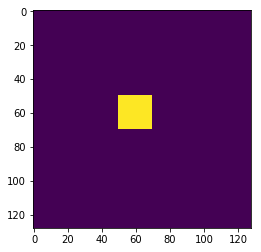

In [1]:
import chainer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import random 
from chainer.functions import log, hstack, huber_loss

# %matplotlib notebook
def get_single_image(pos_r, pos_c, height, width  ): 
    
    image = np.zeros((1,3,128,128), dtype=np.float32)

    gts = []

    for i in range(1):
        # Choose random coordinate, this can also be run in a loop
        width = width
        height =height
        pos_r =pos_r
        pos_c =pos_c
        image[0,:,pos_r:pos_r+height,pos_c:pos_c+width]=1
        #print(pos_r, pos_c)

        cx = pos_c #+ width/2.0
        cy = pos_r #+ height/2.0

        box = [cx, cy, width, height, 1, 0]

        gts.append(box)

    # Create ground truth object
    gts2 = chainer.Variable(np.array(gts, dtype=np.float32))
    return gts2, image 


gt, img  = get_single_image(50,50, 20,20)
for i in range(1):
    # Initialize the image
    
    # Visualize the entire thing
    plt.imshow(img[0,0,:,:])
    plt.show()

In [2]:
print('ground truth box coordinates: ' ,gt,'gt shape :' ,gt.shape)
print('-----------------------------------------------')
print('Image shape', img.shape)


ground truth box coordinates:  variable([[ 50.  50.  20.  20.   1.   0.]]) gt shape : (1, 6)
-----------------------------------------------
Image shape (1, 3, 128, 128)


### Conv net definitions 

In [3]:
from chainer import Chain
import chainer
import chainer.functions as F
import chainer.links as L

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__(
            l1=L.Convolution2D(None,32,ksize=(3,3),stride=1,pad=1),
            l2=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l3=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l4=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.max_pooling_2d(h1, 2)
        h3 = F.relu(self.l2(h2))
        h4 = F.max_pooling_2d(h3, 2)
        h5 = F.relu(self.l3(h4))
#         h6 = F.max_pooling_2d(h5, 2)
#         h7 = F.relu(self.l4(h6))
        
        return self.l3(F.sigmoid(h5))

In [4]:
class BoxNet(Chain):
    def __init__(self, predictor):
        super(BoxNet, self).__init__(
            l1=L.Convolution2D(None,6,ksize=(3,3),stride=1,pad=1)
        )
        self.predictor = predictor
        
    def __call__(self, x):
        h1 = self.l1(self.predictor(x))
        return h1
    
convnet = ConvNet()
boxnet = BoxNet(ConvNet())
fm = convnet(img)
shifts_all = boxnet(img)

shifts= shifts_all[:,:,8,8]
shifts =F.reshape(shifts,[1,6,1,1])


In [5]:
print('shifts all shape :', shifts_all.shape,  ' \n shifts shape :', shifts.shape)
print('------------------------------------------')
print('shifts value :', shifts[0])

shifts all shape : (1, 6, 32, 32)  
 shifts shape : (1, 6, 1, 1)
------------------------------------------
shifts value : variable([[[ 0.0506487 ]]

          [[ 0.01421718]]

          [[-0.63129514]]

          [[-0.21490458]]

          [[-0.06837606]]

          [[ 0.04030652]]])


### Generate Default boxes

In [6]:
def defaultgen(I, F, width, height):
    """
    Generates an array of default boxes: Chainer TESTED
    
    Args:
        I: Input image tensor (N,channels,rows,cols)
        F: Feature map tensor to generate default boxes for
        width: Width of the box
        height: Height of the box
        
    Returns:
        db: Default boxes tensor, flattened
    """
    scale = (I.shape[2] / F.shape[2])
    offset = np.ones((2,F.shape[2],F.shape[3]), dtype=np.float32)
    iterator = np.flip(np.indices((F.shape[2],F.shape[3])), axis=0).astype(np.float32)
    
    xys = offset * ((scale-1)/2) + iterator * scale
    xys = np.moveaxis(xys,0,2)
    ws = np.full((F.shape[2],F.shape[3],1), width, dtype=np.float32)
    hs = np.full((F.shape[2],F.shape[3],1), height,dtype=np.float32)
    class_scores = np.zeros((F.shape[2],F.shape[3],2), dtype=np.float32)
    db = np.dstack([xys, ws, hs, class_scores])
   
    db = db[8,8,:]
    db = db.reshape([1,1,6])
    
    return chainer.Variable(db.reshape((db.shape[0] * db.shape[1], 6)))


In [7]:
def_boxes = defaultgen(img,fm, 60,60)
print('def_boxes values:', def_boxes)
print('---------------------------------------')
print('print shape of def boxes :', def_boxes.shape)

def_boxes values: variable([[ 33.5  33.5  60.   60.    0.    0. ]])
---------------------------------------
print shape of def boxes : (1, 6)


### Center to coords 

This function has been checked, seems correct, some examples below

In [8]:
def center_to_coords(box):
    """ 
    Converts bounding box from (cx, cy, w, h) format to (x1, y1, x2, y2) format
    
    Args:
        box: 6d numpy array
        
    Returns:
        box_transformed: Box in the second format
    
    """
    box_transformed = np.array([box[0]-box[2]/2.0, box[1]-box[3]/2.0, box[0]+box[2]/2.0, box[1]+box[3]/2.0, box[4], box[5]])
    return box_transformed



Checking center to coords...

In [9]:
center_to_coords(def_boxes[0])

array([variable(3.5), variable(3.5), variable(63.5), variable(63.5),
       variable(0.0), variable(0.0)], dtype=object)

In [10]:
# some more checks 

box1= np.array([10,9, 3,3,0,0])
box2= np.array([90,15, 33,33,0,0])

print(center_to_coords(box2), center_to_coords(box1)) 

[  73.5   -1.5  106.5   31.5    0.     0. ] [  8.5   7.5  11.5  10.5   0.    0. ]


### Draw boxes 


In [11]:
def draw_boxes(image, boxes):
    img = image
    plt.figure()
    ax = plt.axes()

    for box in boxes:
        box = center_to_coords(box.data)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        ax.add_patch(p)

    
    return ax
ax  = draw_boxes(img, def_boxes)

### Get prediction boxes 

This seems to be correct as well

In [12]:
def get_pred_boxes(shift_vals, default_boxes ): 
    """
    Get predicted boxes by combining shift values to default boxes
    Input: 

    shift_values : Shifts generated by the network  NDarray (None, Num of Default boxes, 4+num of classes)
    Default boxes  : Default boxes generated by the network NDarray (None, Num of Default boxes, 4+num of classes)

    Output: 

    Predicted boxes  : Predicted boxes, same shape as default boxes  NDarray (None, Num of Default boxes, 4+num of classes)

    """
    
    shift_val_shape= default_boxes.shape
    shift_vals= F.swapaxes(shift_vals,1,3)
    shift_vals= F.reshape(shift_vals,shift_val_shape)
    
    shifts = shift_vals 
    def_boxes= default_boxes
    
    
    cx_pred = (shifts[:,0]*def_boxes[:,2])+def_boxes[:,0]
    cy_pred = (shifts[:,1]*def_boxes[:,3])+def_boxes[:,1]
    
    H_pred = F.exp(shifts[:,3])*def_boxes[:,3]
    W_pred = F.exp(shifts[:,2])*def_boxes[:,2]
    
    class1 = shifts[:,4]
    class2 = shifts[:,5]
    
    
    pred_boxes = F.vstack((cx_pred,cy_pred,W_pred,H_pred, class1, class2))
    pred_boxes = F.transpose(pred_boxes)
    
    return  pred_boxes 

In [13]:
pred_boxes= get_pred_boxes(shifts, def_boxes)
print('prediction box coordinates :', pred_boxes)

prediction box coordinates : variable([[  3.65389214e+01   3.43530312e+01   3.19141502e+01
             4.83971024e+01  -6.83760643e-02   4.03065197e-02]])


In [14]:
shifts

variable([[[[ 0.0506487 ]],

           [[ 0.01421718]],

           [[-0.63129514]],

           [[-0.21490458]],

           [[-0.06837606]],

           [[ 0.04030652]]]])

In [15]:
def_boxes

variable([[ 33.5,  33.5,  60. ,  60. ,   0. ,   0. ]])

### Draw predicted boxes

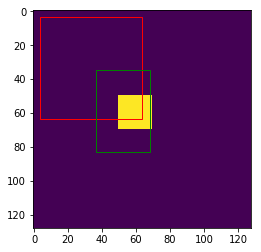

In [16]:

def draw_pred_boxes(prediction_boxes,img, ax): 
    """Draw predicted boxes on the original image """
    
    pred_boxes= prediction_boxes
    
     
    boxes = pred_boxes.data
    
    
    for i in range(pred_boxes.shape[0]):
        box2 =boxes[i]         
        
        box2cx = box2[0]
        box2cy = box2[1]
        
        box2 = center_to_coords(box2)  
        
        ax.imshow(img[0,0,:,:])

        boxes2 = patches.Rectangle((box2cx, box2cy), box2[2]-box2[0], box2[3]-box2[1], fill=False, color = 'green')

        ax.add_patch(boxes2)


    plt.show()

draw_pred_boxes(pred_boxes, img, ax)

### Normalize shifts     

In [17]:

def normalize_shift(box, def_box):
    """
    Scales down absolute shifts, % for centers, log for height and width.
    
    Args:
        box: 6x1 bounding box coordinates
        def_box: 6x1 reference box coordinates
        
    Returns:
        normalized_shift_vector: 4x1 normalized shift vector. Note that we discard the last 2 channels.
    """
    tx = (box[0] - def_box[0])/def_box[2]
    ty = (box[1] - def_box[1])/def_box[3]
    tw = log(box[2]/def_box[2])
    th = log(box[3]/def_box[3])
    
    return hstack([tx, ty, tw, th])
    

### Regression loss 

This too seems to work 

In [18]:
def regression_loss(pred_box, gt_box, def_box):
    """
    Calculates regression loss between two boxes w.r.t a reference default box.
    
    Args:
        pred_box: 6x1 bounding box predicted by the network
        gt_box: 6x1 bounding box overlapping with pred_box
        def_box: 6x1 bounding box with same index as pred_box
        
    Returns:
        reg_loss: Scalar of huber loss between two vectors
    """
    
    gt_normalized  = normalize_shift(gt_box[0],def_box[0])
    pred_normalized = normalize_shift(pred_box[0],def_box[0])
    
    gt_normalized = gt_normalized
    pred_normalized = pred_normalized
    loss_val= pred_normalized - gt_normalized 
   
    x_reg = F.absolute(loss_val )
    x_reg =F.sum(x_reg)
    # for now no sum since there is no other dimension 
    
    return x_reg
    
reg_loss_value = regression_loss(pred_boxes, gt, pred_boxes)
print(' regression loss value :', reg_loss_value)




 regression loss value : variable(2.096118927001953)


In [19]:
def compute_loss(gt_boxes, pred_boxes, def_boxes):
    
    loss_class = chainer.Variable(np.array([0.], dtype=np.float32))
    loss_reg = chainer.Variable(np.array([0.], dtype=np.float32))
    
    gt_box, pred_box, def_box = gt_boxes, pred_boxes, def_boxes    
#     loss_reg += regression_loss(pred_box, gt_box, def_box)
    loss_reg = regression_loss(pred_box, gt_box, def_box)
    
    return loss_reg 


### Eveyrthing connected

Now we connect it all and first test x regression, they y regression and then combination of both


In [20]:
from chainer.optimizers import SGD,Adam,MomentumSGD
from tqdm import tqdm
import matplotlib.pyplot as plt

def all_connected(posr, posc, width_gt, height_gt, alpha, number_loops):
    """
    Input

    width_gt     : width of the ground truth box 
    height_gt    : height of the ground truth box 
    alpha        : alpha value for the adam optimizer 
    number_loops : number of examples generate


    Ouput 
    Image of the loss function 
    Loss history 
    """

    
    
    boxnet = BoxNet(ConvNet())

    optimizer =Adam(alpha= alpha)
    optimizer.setup(boxnet)
    loss_history = []



    for i in tqdm(range(number_loops)):
     
        gt, img =get_single_image(posr, posc, width_gt, height_gt)


        # Initializing the network and computing the features and shifts
        #fm = convnet(img)
        shifts2 = boxnet(img)
        shifts2= shifts2[:,:,8,8]
        shifts2 =F.reshape(shifts2,[1,6,1,1])


        # Getting default_boxes and predictions
        # Forward pass ends here

        def_boxes2 = defaultgen(img, fm,120 ,120)
        pred_boxes2 = get_pred_boxes(shifts2, def_boxes2)

    # #     print(pred_boxes)

    #     # Computing the loss
        boxnet.zerograds()
        loss = compute_loss( gt ,pred_boxes2, def_boxes2)

    #     if i % 50 == 0:
    #         draw_pred_boxes(pred_boxes2,img, ax)
    #         print('pred box loc:  ' , pred_boxes2[0][0],pred_boxes2[0][1] )
    #         print('gt', gt)

        loss_history.append(loss.data)
        loss.backward()

        optimizer.update()

#     plt.figure(figsize=(30,10))
#     plt.plot(range(len(loss_history)), loss_history)
#     plt.ylim([0,1])
#     plt.show()

    return loss_history, pred_boxes2,def_boxes2,  gt,img 



## Experiments 

In all experiments using, adam optimizer- 

First case is where we have a 20 by 20 box located at 50, 50 for 100 runs using a rate of 0.01  

In [21]:
# all_losses = []
# alpha = 0.01
# locx= 50 
# locy= 50
# size= 20
# nloops= 100 
# ensemble = 5
# for i in range(ensemble): 
    
#     loss_history, pred_boxes2, ground_truth,image = all_connected(locx,locy, size,size, alpha, nloops)
#     all_losses.append(loss_history)

    
# all_losses = np.array(all_losses)
# all_losses2 = all_losses.transpose()
# all_losses2.shape   

In [22]:
# random_or_not = 'no'
# plt.figure(figsize=(30,10))
# plt.xlabel('number of runs', size =20)
# plt.ylabel('Loss value', size =20)
# title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
# plt.title(title_name, size=22 )
# plt.ylim([0,1])
# plt.plot(range(len(loss_history)), np.mean(all_losses2,axis=1))
# plt.savefig(title_name+'.png')
# plt.show()


Second case is where we have a 5 by 5 box located at 50, 50 for 100 runs using a rate of 0.0001  

In [23]:
# all_losses = []
# alpha = 0.0001
# locx= 50 
# locy= 50
# size= 5
# nloops= 300 
# ensemble = 5

# for i in range(ensemble): 
    
#     loss_history, pred_boxes2, ground_truth,image = all_connected(locx,locy, size,size, alpha, nloops)
#     all_losses.append(loss_history)

    
# all_losses = np.array(all_losses)
# all_losses2 = all_losses.transpose()
# all_losses2.shape  




# random_or_not = 'no'
# plt.figure(figsize=(30,10))
# plt.xlabel('number of runs', size =20)
# plt.ylabel('Loss value', size =20)
# title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
# plt.title(title_name, size=22 )
# plt.ylim([0,1])
# plt.plot(range(len(loss_history)), np.mean(all_losses2,axis=1))
# plt.savefig(title_name+'.png')
# plt.show()

In [24]:
# all_losses = []
# alpha = 0.0001
# locx= np.random.randint(10, 60) 
# locy= 50
# size= 5
# nloops= 300 
# ensemble = 5

# for i in range(ensemble): 
    
#     loss_history, pred_boxes2, ground_truth, image = all_connected(locx,locy, size,size, alpha, nloops)
#     all_losses.append(loss_history)

    
# all_losses = np.array(all_losses)
# all_losses2 = all_losses.transpose()
# all_losses2.shape  




# random_or_not = 'random_x'
# plt.figure(figsize=(30,10))
# plt.xlabel('number of runs', size =20)
# plt.ylabel('Loss value', size =20)
# title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
# plt.title(title_name, size=22 )
# plt.ylim([0,1])
# plt.plot(range(len(loss_history)), np.mean(all_losses2,axis=1))
# plt.savefig(title_name+'.png')
# plt.show()

100%|██████████| 300/300 [00:18<00:00, 16.20it/s]


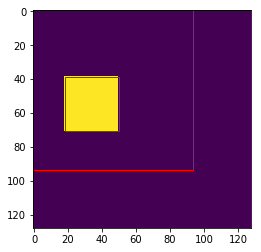

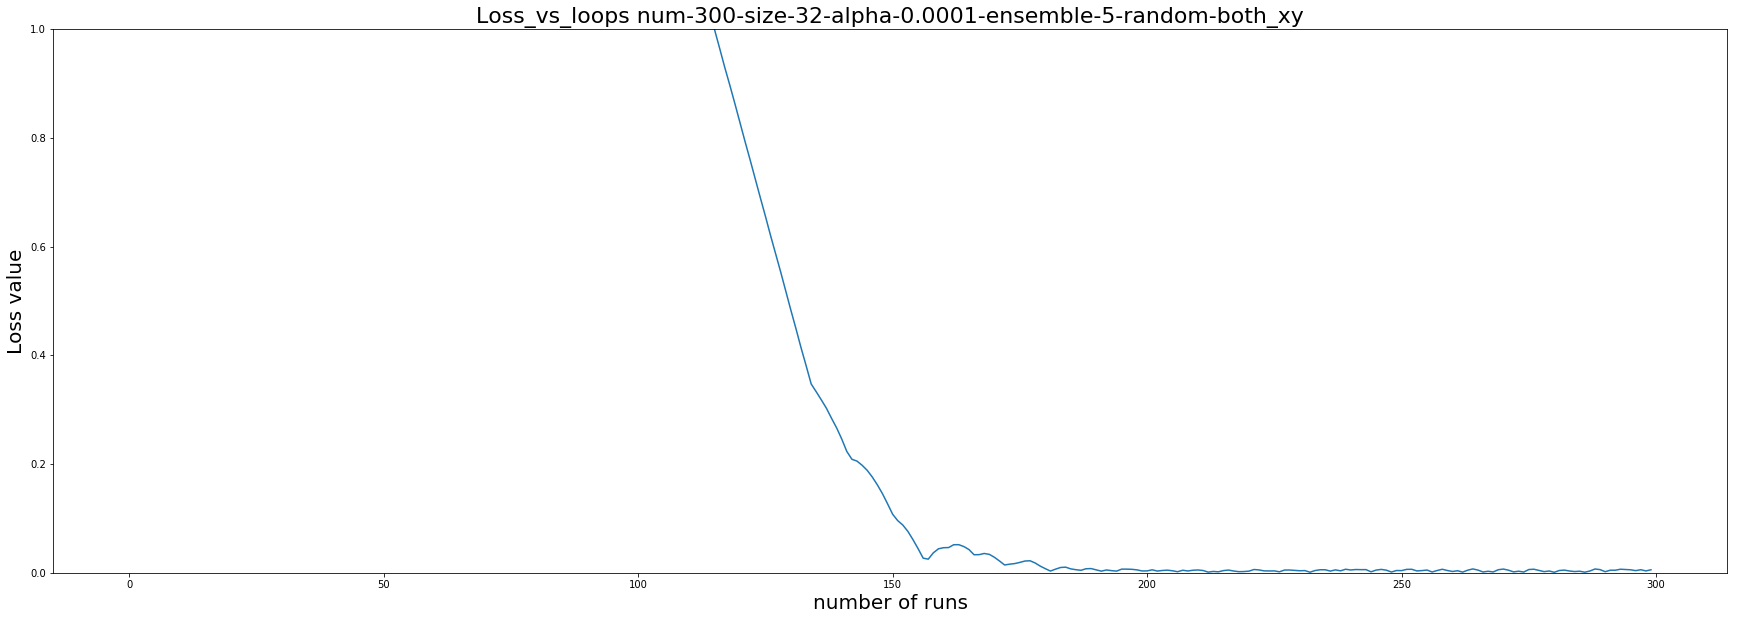

100%|██████████| 300/300 [00:19<00:00, 16.38it/s]


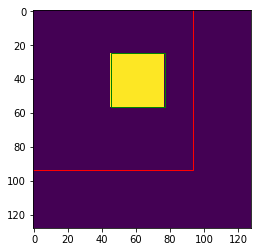

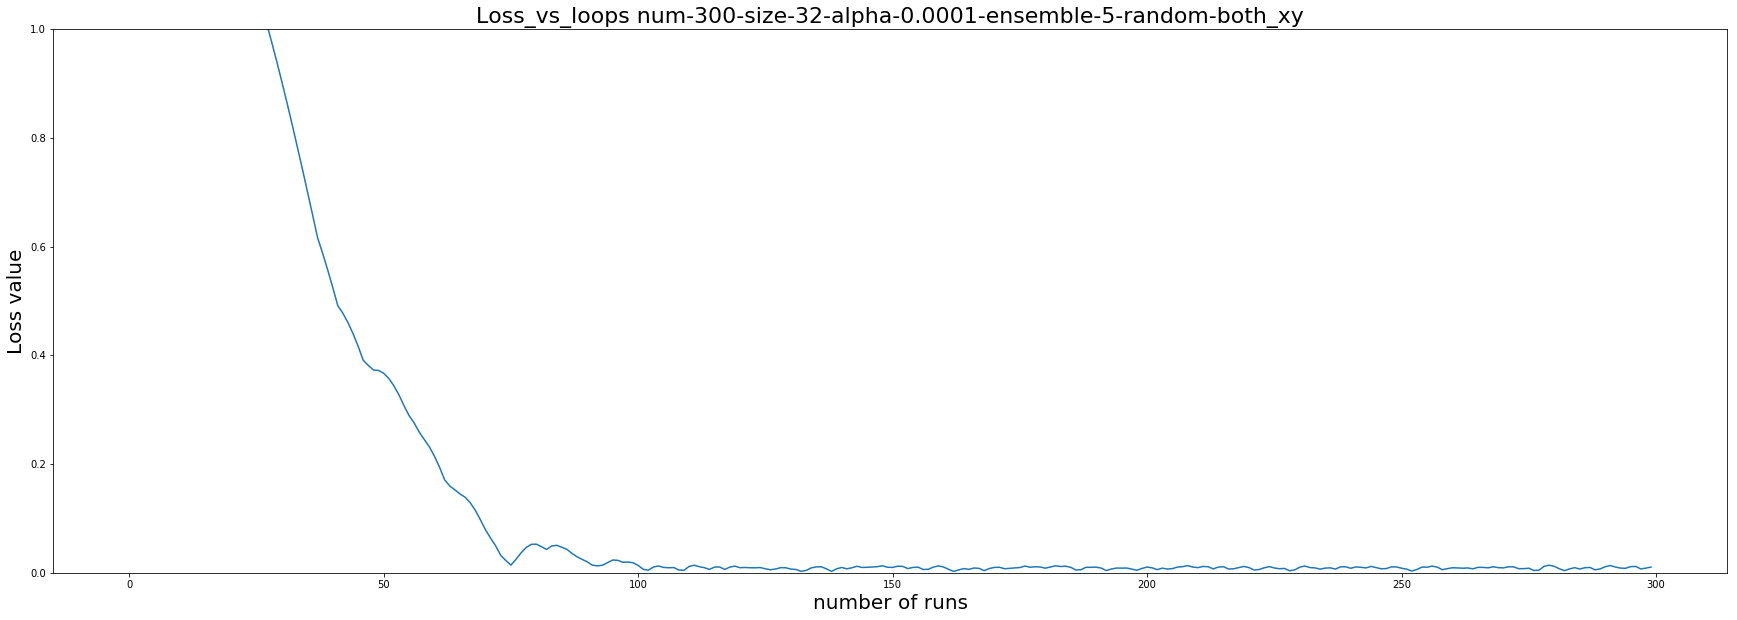

100%|██████████| 300/300 [00:19<00:00, 15.19it/s]


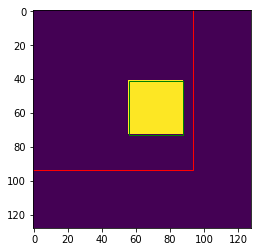

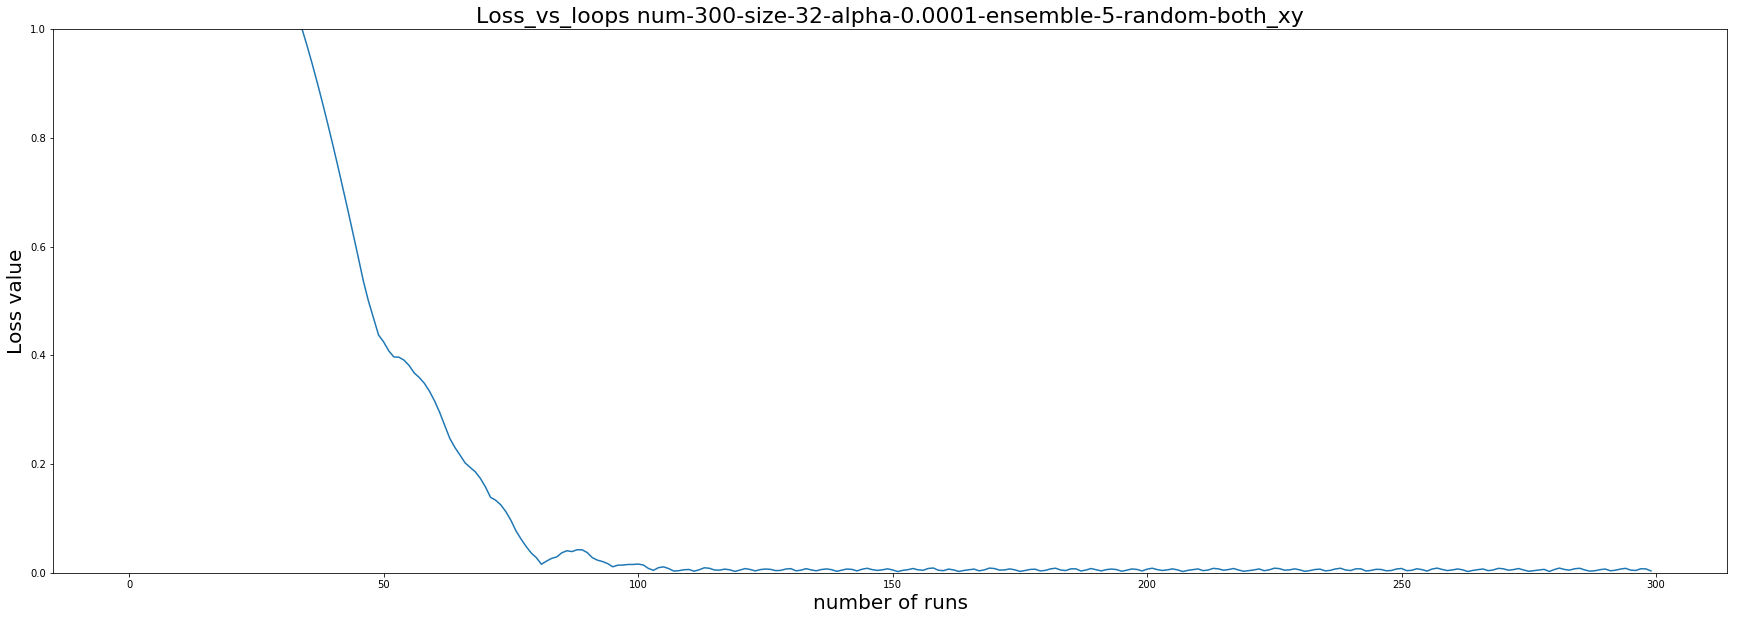

  6%|▌         | 18/300 [00:01<00:17, 15.96it/s]


KeyboardInterrupt: 

In [28]:
all_losses = []
alpha = 0.0001
locx= np.random.randint(10, 60) 
locy= np.random.randint(10, 60) 
size= np.random.randint(5, 50)
nloops= 300 
ensemble = 5

for i in range(ensemble): 

    locx= np.random.randint(10, 60) 
    locy= np.random.randint(10, 60) 

    loss_history, pred_boxes2, def_boxes, ground_truth, image = all_connected(locx,locy, size,size, alpha, nloops)
    ax=draw_boxes(image,def_boxes)
    draw_pred_boxes(pred_boxes2, image, ax)
    all_losses.append(loss_history)

    
    random_or_not = 'both_xy'
    plt.figure(figsize=(30,10))
    plt.xlabel('number of runs', size =20)
    plt.ylabel('Loss value', size =20)
    title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
    plt.title(title_name, size=22 )
    plt.ylim([0,1])
    plt.plot(range(len(loss_history)), loss_history)
    # plt.savefig(title_name+'.png')
    plt.show()
    
    
    
    
    
    
    
    
all_losses = np.array(all_losses)
all_losses2 = all_losses.transpose()
all_losses2.shape  




# random_or_not = 'both_xy'
# plt.figure(figsize=(30,10))
# plt.xlabel('number of runs', size =20)
# plt.ylabel('Loss value', size =20)
# title_name ='Loss_vs_loops num-'+ str(nloops)+ '-size-'+ str(size) + '-alpha-'+ str(alpha)+'-ensemble-'+str(ensemble)+'-random-'+random_or_not
# plt.title(title_name, size=22 )
# plt.ylim([0,1])
# plt.plot(range(len(loss_history)), np.mean(all_losses2,axis=1))
# # plt.savefig(title_name+'.png')
# plt.show()

In [26]:
ground_truth

variable([[ 56.,  47.,  20.,  20.,   1.,   0.]])

In [27]:
pred_boxes2

variable([[  5.83396225e+01,   4.72363739e+01,   1.98345184e+01,
             2.05226593e+01,   1.02071702e+00,  -8.24875291e-03]])